In [43]:
import numpy as np
# import pandas as pd
import scipy.io
from matplotlib import pyplot as plt

In [44]:
peaks = scipy.io.loadmat('PeaksData.mat')
x_train = np.array(peaks['Yt'])
y_train = np.array(peaks['Ct'])
x_val = np.array(peaks['Yv'])
y_val = np.array(peaks['Cv'])
print(x_train.shape)
print(y_train.shape)

(2, 25000)
(5, 25000)


let's explore some of the data:

In [45]:
print(x_train[:,1])
print(y_train[:,1])
print(x_train[:,0:5])

[ 0.67857397 -1.355821  ]
[1. 0. 0. 0. 0.]
[[ 0.6316706   0.67857397 -0.1523986   0.6432767   0.39615428]
 [-1.8902596  -1.355821   -2.0039823  -1.7331227  -1.9908634 ]]


#**Part 1: the classifier and optimizer**

 **1. SoftMax Regression** \

*we also provide tests comparing our results to the well-known deep learning
framework torch.*

In [46]:
import numpy as np
# import torch #only for tests

class SoftmaxModule:

    def __init__(self, n, l):
        # n is the length of input vector, l is number of classes
        self.W = np.random.randn(n, l)#*0.5   # change this potentially
        self.B = np.zeros((1,l))#np.random.rand(1,l) * 0.5
        self.X = None # cache X
        self.C = None # cache C
        self.A = None # cache A(activation, i.e. softmax output)

    def softmax_forward(self, X,bias=True,cache = True):
        """

        :param X: X tensor of shape n,m where m is number of training examples
        :param bias: whether to add bias or not, just for testing
        :return: softmax output of shape l*m where l is the number of classes
        """

        # shape of W is n,l. shape of X is n,m.
        if bias:
            temp_X = np.concatenate((X, np.ones((1, X.shape[1]))), axis=0)  # shape n+1,m
            temp = temp_X.T @ np.concatenate((self.W,self.B),axis=0)  # shape of temp is m,l
        else:
            temp = X.T @ self.W #shape is m,l
        temp_max = np.max(temp, axis=1, keepdims=True) # shape is m,1
        temp = temp - temp_max # broadcasting
        exp = np.exp(temp)  # shape of exp is m,l
        # print("shape of exp: %s" % str(exp.shape))
        sum = np.sum(exp, axis=1, keepdims=True)  # shape of sum is m,1
        # print("shape of sum: %s" % str(sum.shape))
        out = exp / sum  # shape of out is m,l
        if cache:
          self.A = out # cache A
        return out

    def cross_entropy_forward(self, X, C):
        """

        :param X: output of softmax_forward, shape m,l
        :param C: matrix of true labels, shape l,m
        :return: cross entropy loss over all training examples
        """
        t = C.T * np.log(X)  # shape m,l
        l_sum = np.sum(t, axis=1)  # shape m
        return -1 * np.mean(l_sum)

    def loss_forward(self, X, C,cache = True):
        """

        :param X: input matrix of size n*m
        :param C: matrix of true labels, shape l,m
        :return: the function returns the cross entropy loss
        """
        ##CACHE X and C
        if cache:
          self.X = X
          self.C = C
        return self.cross_entropy_forward(self.softmax_forward(X,cache = cache), C)

    def grad(self):
        """

        :return: (dX,dW,dB)

        """
        # A.shape is m,l so we need to transpose it when computing dx
        # W.shape is n,l
        # X.shape is n,m
        m = self.X.shape[1]
        dX = (1/m)*self.W @ (self.A.T-self.C) # shape n,m
        temp_X = np.concatenate((self.X, np.ones((1, self.X.shape[1]))), axis=0)  # shape n+1,m. this is for bias
        dWB = (1/m)*temp_X @ (self.A-self.C.T) # shape n+1,l
        # now we need to separate dW and dB
        dW = dWB[:-1,:]
        dB = dWB[-1:,:]
        return dX,dW,dB # TODO: jacobian test

    def grad_test(self):
        X = self.X
        C = self.C
        epsilon = [(0.5)**i for i in range(0,10)]
        o_eps = []
        o_eps_squared = []
        dX,dW,dB= self.grad()
        dW  = np.dot(X.T, self.A - C.T)/X.shape[0]
        dB = np.sum(self.A - C.T, axis=0)/X.shape[0]
        grad_x= np.mean(np.dot(self.W, (self.A - C.T).T))
        dX = grad_x

        ### FOR dX ####
        d = np.random.rand(self.X.shape[0],self.X.shape[1])
        d = d/np.linalg.norm(d)
        for eps in epsilon:
            f_x_eps = self.loss_forward(X+(d*eps),C,cache=False)
            f_x = self.loss_forward(X,C,cache=False)
            o_eps.append(np.abs(f_x_eps-f_x))
            temp = np.vdot(d,dX)*eps
            temp_o_squared = np.abs(f_x_eps-f_x-temp)
            o_eps_squared.append(temp_o_squared)
        #now plot both o_eps and o_eps_squared
        # plt.plot()
        plt.plot(o_eps,label="without gradient",color="red")
        plt.plot(o_eps_squared,label="with gradient",color="blue")
        plt.yscale("log")
        plt.ylabel("difference")
        plt.legend()
        plt.title("softmax: dL/dX")
        plt.show()

        ##FOR W ##
        o_eps = []
        o_eps_squared = []
        d = np.random.rand(self.W.shape[0],self.W.shape[1])
        d = d/np.linalg.norm(d)
        for eps in epsilon:
            temp = self.W
            self.W = self.W+d*eps
            f_x_eps = self.loss_forward(X,C,cache=False)
            self.W = temp
            f_x = self.loss_forward(X,C,cache=False)
            # torch_test = ce(torch.Tensor(X.T @ self.W),torch.Tensor(C.T))
            temp_o = np.abs(f_x_eps-f_x)
            o_eps.append(np.abs(f_x_eps-f_x))
            temp = np.vdot(d,dW)*eps
            temp_o_squared = np.abs(f_x_eps-f_x-temp)
            # print("o(eps): %s, o(eps)^2: %s, epsilon: %s" % (str(temp_o),str(temp_o_squared),str(eps)))
            o_eps_squared.append(temp_o_squared)
        #now plot both o_eps and o_eps_squared
        # plt.plot()
        plt.plot(o_eps,label="without gradient",color="red")
        plt.plot(o_eps_squared,label="with gradient",color="blue")
        plt.yscale("log")
        plt.ylabel("difference")
        plt.legend()
        plt.title("softmax: dL/dW")
        plt.show()
        ## FOR B ##
        o_eps = []
        o_eps_squared = []
        d = np.random.rand(self.B.shape[0],self.B.shape[1])
        d = d/np.linalg.norm(d)
        for eps in epsilon:
            temp = self.B
            self.B = self.B+d*eps
            f_x_eps = self.loss_forward(X,C,cache=False)
            self.B = temp
            f_x = self.loss_forward(X,C,cache=False)
            # torch_test = ce(torch.Tensor(X.T @ self.W),torch.Tensor(C.T))
            temp_o = np.abs(f_x_eps-f_x)
            o_eps.append(np.abs(f_x_eps-f_x))
            temp = np.vdot(d,dB)*eps
            temp_o_squared = np.abs(f_x_eps-f_x-temp)
            # print("o(eps): %s, o(eps)^2: %s, epsilon: %s" % (str(temp_o),str(temp_o_squared),str(eps)))
            o_eps_squared.append(temp_o_squared)
        #now plot both o_eps and o_eps_squared
        # plt.plot()
        plt.plot(o_eps,label="without gradient",color="red")
        plt.plot(o_eps_squared,label="with gradient",color="blue")
        plt.yscale("log")
        plt.ylabel("difference")
        plt.legend()
        plt.title("softmax: dL/dB")
        plt.show()



if __name__ == "__main__":
    # test softmax
    
    pass
    n = 2
    l = 5
    m = 3
    X = np.random.rand(n, m)
    # np.eye(n_classes)[np.random.choice(n_classes, n_samples)]
    C =np.eye(l)[np.random.choice(l, m)].T
    print("X: %s" % str(X.shape))
    print("C: %s" % str(C.shape))
    # print("X: %s" % X)
    # print("C: %s" % C)
    sm = SoftmaxModule(n, l)
    # out = sm.softmax_forward(X,False)
    # print("our_softmax_out: %s" % str(out))
    # # loss = sm.cross_entropy_forward(out, C)
    # # print("loss: %s" % loss)
    # test = X.T @ sm.W
    # # print("test: %s" % str(test.shape))
    # sm_test = torch.nn.functional.softmax(torch.Tensor(test), dim=1)
    # # ce_test = torch.nn.functional.cross_entropy(torch.Tensor(sm_test), torch.Tensor(C))
    # print("sm_test_torch: %s" % str(sm_test))

    # ce = sm.cross_entropy_forward(out,C)
    # print("our_ce: %s" % ce)


    # # test cross entropy
    # ce_torch = torch.nn.CrossEntropyLoss()
    # ce_test = ce_torch(torch.Tensor(test), torch.Tensor(C.T))
    # print("ce_test_torch: %s" % ce_test)

    # # now let's test if the bias works
    # b = np.random.rand(1,l)
    # sm.B = b
    # test = test+b
    # sm_bias = sm.softmax_forward(X,bias=True)
    # print("sm_bias: %s" % str(sm_bias))
    # sm_test = torch.nn.functional.softmax(torch.Tensor(test), dim=1)
    # print("sm_bias_torch: %s" % str(sm_test))

X: (2, 3)
C: (5, 3)


## ***Gradient Tests:***

[[0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]]


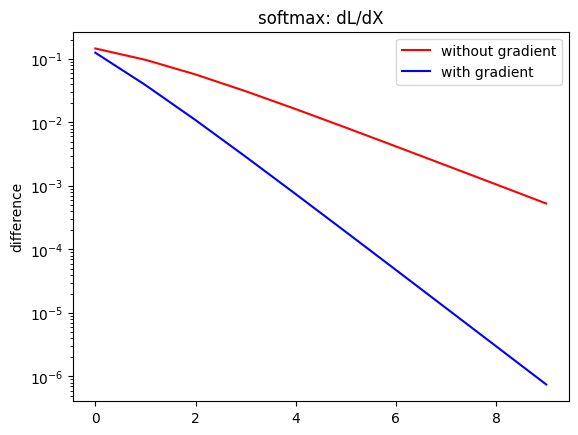

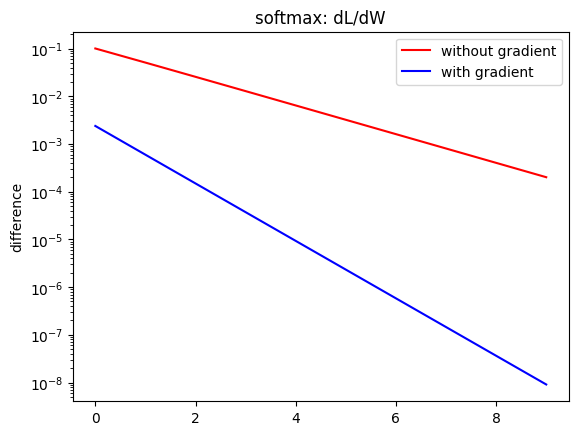

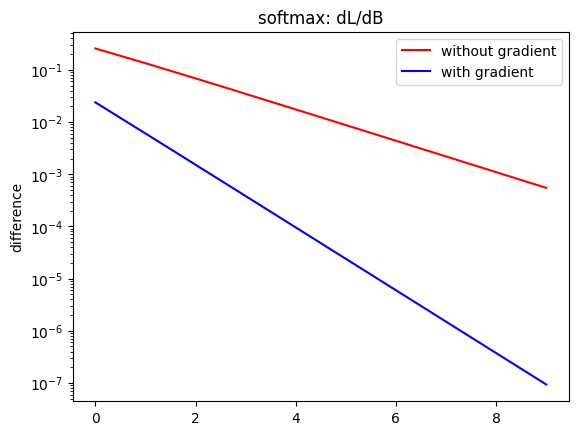

In [47]:
np.random.seed(42)
n = 1
l = 5
m = 1
X = np.random.rand(n, m) #100 data points, each 1 features
y = np.eye(l, m)  # Assuming 5 classes for softmax regression , one-hot encoding
weights = np.random.rand(1, 5) # 1 feature, 3 classes
biases = np.random.rand(5)
print(weights)
sm = SoftmaxModule(n, l)
sm.loss_forward(X,y)
sm.grad_test()

## least squares & SGD

epoch 0 :  24.234337533273926
epoch 1000 :  0.6157341697532125
epoch 2000 :  0.017275265807674325
epoch 3000 :  0.0004843924717751171
epoch 4000 :  1.3593613649784097e-05
epoch 5000 :  3.814378270037718e-07
epoch 6000 :  1.070657337614206e-08
epoch 7000 :  3.0041904919732693e-10


epoch 8000 :  8.434405286343298e-12
epoch 9000 :  2.3662292128730365e-13
epoch 10000 :  6.659736860004585e-15
[[9.99999987e-01 1.44284461e-08]
 [1.28410413e-08 9.99999986e-01]]


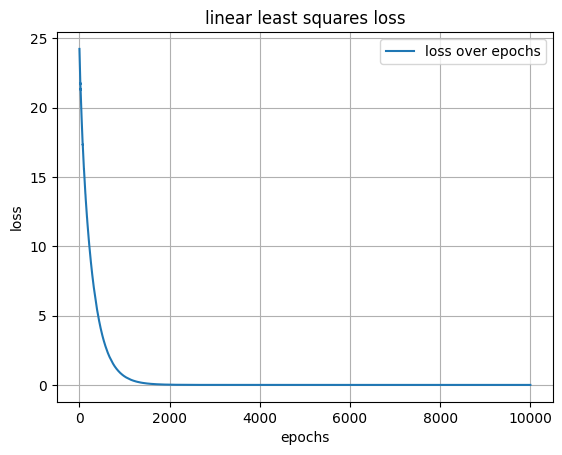

In [48]:
from numpy import linalg as LNG
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.random.rand(2, 200)

w = np.random.rand(2, 2)

epochs = 10000
learning_rate = 0.0001
mini_size = 32

def create_minibatches(x, size):
    N, M = x.shape

    # Calculate the number of subarrays
    num_batches = np.ceil(N / size)

    #shuffle the minibatches
    np.random.shuffle(x)

    # Divide the array into subarrays along the first dimension
    x_batch = np.split(x, num_batches, axis=1)

    return x_batch

#X.shape - (N, mini_size)
#W.shape - (N, N)
def grad2(X,W):
  return X.dot(X.T).dot(W) - X.dot(X.T)

loss_graph = []

def SGD(x, w, minibatch_size, learning_rate, epoch_num):
  index = 0
  for epoch in range(epoch_num):
    loss_epoch = []
    #create minibatches
    x_batch = create_minibatches(x, minibatch_size)
    for mini in x_batch:
      dw = grad2(mini, w)
      w = w - learning_rate * dw
      loss_mini = 0.5 * (np.linalg.norm(w.T.dot(mini) - mini) ** 2)
      loss_epoch.append(loss_mini)

    loss = sum(loss_epoch) / len(x_batch)
    loss_graph.append(loss)
    if index % 1000 == 0:
      print("epoch", index, ": ", loss)
    index = index+1
  print("epoch", index, ": ", loss)

  print(w)

SGD(x, w, mini_size, learning_rate, epochs)

plt.plot(range(0, epochs), loss_graph, label='loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('linear least squares loss')
plt.grid(True)
plt.legend()
plt.show()

note that W is converging to the identity matrix, as expected, because we train our model using the same data for the input and the true labels.

## Training the softmax regression module

In [49]:
def calculate_accuracy(predictions, true_labels):
    # Assuming predictions and true_labels are numpy arrays
    num_correct = np.sum(predictions == true_labels)
    accuracy = num_correct / len(true_labels)
    return accuracy


25000
6250
Epoch 1/1000
Epoch 11/1000
Epoch 21/1000
Epoch 31/1000
Epoch 41/1000
Epoch 51/1000
Epoch 61/1000
Epoch 71/1000
Epoch 81/1000
Epoch 91/1000
Epoch 101/1000
Epoch 111/1000
Epoch 121/1000
Epoch 131/1000
Epoch 141/1000
Epoch 151/1000
Epoch 161/1000
Epoch 171/1000
Epoch 181/1000
Epoch 191/1000
Epoch 201/1000
Epoch 211/1000
Epoch 221/1000
Epoch 231/1000
Epoch 241/1000
Epoch 251/1000
Epoch 261/1000
Epoch 271/1000
Epoch 281/1000
Epoch 291/1000
Epoch 301/1000
Epoch 311/1000
Epoch 321/1000
Epoch 331/1000
Epoch 341/1000
Epoch 351/1000
Epoch 361/1000
Epoch 371/1000
Epoch 381/1000
Epoch 391/1000
Epoch 401/1000
Epoch 411/1000
Epoch 421/1000
Epoch 431/1000
Epoch 441/1000
Epoch 451/1000
Epoch 461/1000
Epoch 471/1000
Epoch 481/1000
Epoch 491/1000
Epoch 501/1000
Epoch 511/1000
Epoch 521/1000
Epoch 531/1000
Epoch 541/1000
Epoch 551/1000
Epoch 561/1000
Epoch 571/1000
Epoch 581/1000
Epoch 591/1000
Epoch 601/1000
Epoch 611/1000
Epoch 621/1000
Epoch 631/1000
Epoch 641/1000
Epoch 651/1000
Epoch 661/

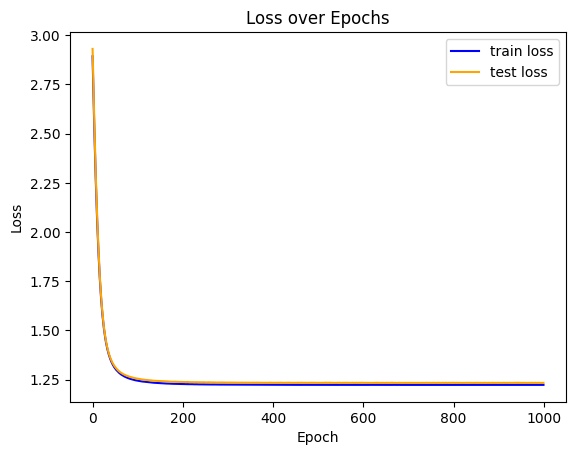

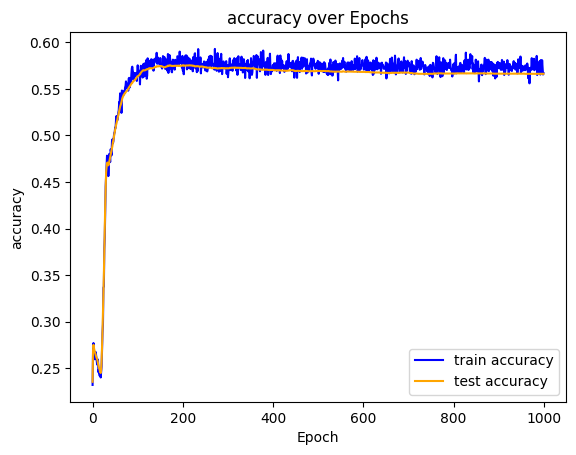

Training completed.


In [50]:

sr = SoftmaxModule(x_train.shape[0],y_train.shape[0]) #n,l
# y_train_true = np.argmax(y_train,axis = 0)
# y_val_true = np.argmax(y_val,axis = 0)
num_data_points_train = x_train.shape[1]
num_data_points_val = x_val.shape[1]
print(num_data_points_train)
print(num_data_points_val)
batch_size = 64
accuracy_batch_size = 6250
num_batches_train = num_data_points_train//batch_size
num_batches_val = num_data_points_val//batch_size
epochs = 1000
lr = 0.000325
losses_train = []
losses_val = []
accuracies_train = []
accuracies_val = []
for epoch in range(epochs):

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}")

    # Shuffle the data indices for each epoch

    # Iterate over the data in batches
    loss_train = 0
    loss_val = 0
    # correct_train = 0
    # correct_val = 0


    indices_train = np.arange(num_data_points_train)
    np.random.shuffle(indices_train)
    indices_val = np.arange(num_data_points_val)
    np.random.shuffle(indices_val)

    ## val data ##
    for i in range(0,num_data_points_val,batch_size):
        batch_indices = indices_val[i:i+batch_size]
        x_batch_v = x_val[:, batch_indices]
        y_batch_v = y_val[:, batch_indices]
        loss_val+=sr.loss_forward(x_batch_v,y_batch_v)




    ## training data ##
    for i in range(0, num_data_points_train, batch_size):
        batch_indices = indices_train[i:i+batch_size]

        # Get batch data
        x_batch = x_train[:, batch_indices] #n,B
        y_batch = y_train[:, batch_indices] #l,B

        loss_train += sr.loss_forward(x_batch,y_batch)
        # losses.append(sr.loss_forward(x_batch,y_batch))
        dX,dW,dB = sr.grad()
        sr.W = sr.W - lr*dW
        sr.B = sr.B - lr*dB



    ## test accuracy for training data ##
    x_batch = x_train[:,indices_train[:accuracy_batch_size]] #n,B
    y_batch = y_train[:, indices_train[:accuracy_batch_size]] #l,B
    predicted = np.argmax(sr.softmax_forward(x_batch,cache = False).T,axis=0)#1,m
    true_labels = np.argmax(y_batch,axis = 0)#1,m
    accuracies_train.append(calculate_accuracy(predicted,true_labels))
    ## test accuracy for val data ##
    x_batch = x_val[:,indices_val[:accuracy_batch_size]] #n,B
    y_batch = y_val[:, indices_val[:accuracy_batch_size]] #l,B
    predicted = np.argmax(sr.softmax_forward(x_batch,cache = False).T,axis=0)#1,m
    true_labels = np.argmax(y_batch,axis = 0)#1,m
    accuracies_val.append(calculate_accuracy(predicted,true_labels))




    loss_train/= num_batches_train
    loss_val/=num_batches_val
    losses_train.append(loss_train)
    losses_val.append(loss_val)

plt.plot(losses_train,label="train loss",color="blue")
plt.plot(losses_val,label = "test loss",color = "orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()
plt.plot(accuracies_train,label="train accuracy",color="blue")
plt.plot(accuracies_val,label = "test accuracy",color = "orange")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('accuracy over Epochs')
plt.legend()
plt.show()


print("Training completed.")


Here, we've demonstrated our most successful hyperparameter configuration. This run was configured with a learning rate of 0.000325, 1000 epochs, and a batch size of 32. We've tried several combinations, such as higher and lower learning rates, different batch sizes, and different numbers of epochs. For example, we've tried learning rates such as 0.001, 0.0001, 0.1, and more. We've also experimented with several batch sizes, such as 16, 32, 64, 256, and 2048. Additionally, we attempted treating the entire training set as a batch, performing each parameter update after going through the entire dataset.

# The Neural Network

First, lets create our Neural network building blocks.
In our case, we'll use either a simple linear layer, or a residual block.

In [51]:
def plot_grad_test(epsilon, o_eps, o_eps_squared, title):
    plt.plot(o_eps, label="without gradient", color="red")
    plt.plot(o_eps_squared, label="with gradient", color="blue")
    plt.yscale("log")
    # plt.xscale("log")
    # plt.xlabel("epsilon")
    plt.ylabel("difference")
    plt.legend()
    plt.title(title)
    plt.show()


class HiddenModule:

    def forward(self, X, cache=True):
        pass

    def update_params(self, dX_prev, lr):
        pass

    def grad(self, dX_prev):
        pass

    def jac_test(self):
        pass

    def set_param(self, param, value):
        pass
    def perform_jac_test(self, parameters, epsilon, u, layer_title):
        for (param, param_name, gradient, name) in parameters:
            o_eps = []
            o_eps_squared = []

            d = np.random.rand(*param.shape)
            d = d / np.linalg.norm(d)

            for eps in epsilon:
                temp = param.copy()
                self.set_param(name, param + d * eps)

                f_x_eps = np.vdot(u, self.forward(self.X, cache=False))
                self.set_param(name, temp)
                f_x = np.vdot(u, self.forward(self.X, cache=False))

                o_eps.append(np.abs(f_x_eps - f_x))

                temp_gradient = np.vdot(d, gradient) * eps
                temp_o_squared = np.abs(f_x_eps - f_x - temp_gradient)
                o_eps_squared.append(temp_o_squared)

            plot_grad_test(epsilon, o_eps, o_eps_squared, param_name + " " + layer_title)


class Linear(HiddenModule):

    def __init__(self, in_dim, out_dim, activation='tanh'):

        match activation:
            case 'relu':
                self.activation = lambda x: np.maximum(0, x)
                self.activation_grad = lambda x: np.where(x > 0, 1, 0)
            case 'sigmoid':
                self.activation = lambda x: 1 / (1 + np.exp(-x))
                self.activation_grad = lambda x: self.activation(x) * (1 - self.activation(x))
            case 'tanh':
                self.activation = lambda x: np.tanh(x)
                self.activation_grad = lambda x: 1 - np.tanh(x) ** 2
            case None:
                self.activation = lambda x: x
                self.activation_grad = lambda x: 1
        self.W = np.random.randn(out_dim, in_dim) * 0.5
        self.b = np.zeros((out_dim, 1))
        self.X = None  # cache X
        self.Z = None  # cahse Z

    def forward(self, X, cache=True):
        """
        :param X: input matrix of size n*m
        :return: the function returns the output of the linear layer
        """
        z = self.W @ X + self.b
        a = self.activation(z)
        if cache:
            self.X = X
            self.Z = z
        return a

    def grad(self, dX_prev):
        """
        :param dX_prev: if current layer is L, dX_prev is dX of L+1. shape is n,m. this is essentially the vector V from the notes.
        :return: current dX, dW, db
        """
        act_grad = self.activation_grad(self.Z)  # shape is n,m
        dB = np.sum(dX_prev * act_grad, axis=1, keepdims=True)  # shape is n,1(out_dim,1)
        dW = dX_prev * act_grad @ self.X.T
        dX = self.W.T @ (dX_prev * act_grad)  # shape is in_dim,m
        return dX, dW, dB

    def update_params(self, dX_prev, lr):
        """

        :param dX_prev:
        :param lr:
        :return: the function return dX of the current layer for further backprop
        """
        dX, dW, dB = self.grad(dX_prev)
        self.W = self.W - lr * dW
        self.b = self.b - lr * dB
        return dX

    def set_param(self, param, value):
        match param:
            case 'W':
                self.W = value
            case 'b':
                self.b = value
            case 'X':
                self.X = value



    def jac_test(self,layer_title):
        epsilon = [(0.5) ** i for i in range(0, 10)]
        u = np.random.rand(self.W.shape[0], self.X.shape[1])  # out_dim,m
        dX, dW, dB = self.grad(u)
        parameters = [(self.X, "dX", dX, 'X'), (self.W, "dW", dW, 'W'), (self.b, "dB", dB, 'b')]
        self.perform_jac_test(parameters, epsilon, u, layer_title)

class ResNetBlock(HiddenModule):

    def __init__(self, in_dim, mid_dim, activation='tanh'):
        self.layer1 = Linear(in_dim, mid_dim, activation=activation)
        self.layer2 = Linear(mid_dim, in_dim, activation=None)  # we will not use this activation
        self.activation = self.layer1.activation
        self.activation_grad = self.layer1.activation_grad
        self.X = None
        self.Z = None  # cache Z

    def forward(self, X, cache=True):
        A = self.layer1.forward(X)
        Z = self.layer2.forward(A) + X
        if cache:
            self.X = X
            self.Z = Z

        return self.activation(Z)

    def grad(self, dX_prev):
        act_grad = self.activation_grad(self.Z)
        dW2 = dX_prev * act_grad @ self.layer1.activation(self.layer1.Z).T
        dB2 = np.sum(dX_prev * act_grad, axis=1, keepdims=True)
        dA = self.layer2.W.T @ (dX_prev * act_grad)
        act_grad_2 = self.layer1.activation_grad(self.layer1.Z)
        dW1 = dA * act_grad_2 @ self.layer1.X.T
        dB1 = np.sum(dA * act_grad_2, axis=1, keepdims=True)
        dX = self.layer1.W.T @ (dA * act_grad_2) + dX_prev * act_grad
        return dX, dW1, dB1, dW2, dB2

    def update_params(self, dX_prev, lr):
        dX, dW1, dB1, dW2, dB2 = self.grad(dX_prev)
        self.layer1.W = self.layer1.W - lr * dW1
        self.layer1.b = self.layer1.b - lr * dB1
        self.layer2.W = self.layer2.W - lr * dW2
        self.layer2.b = self.layer2.b - lr * dB2
        return dX


    def set_param(self, param, value):
        match param:
            case 'W1':
                self.layer1.W = value
            case 'b1':
                self.layer1.b = value
            case 'W2':
                self.layer2.W = value
            case 'b2':
                self.layer2.b = value
            case 'X':
                self.X = value

    def jac_test(self,layer_title):
        epsilon = [(0.5) ** i for i in range(0, 10)]
        u = np.random.rand(self.layer2.W.shape[0], X.shape[1])  # out_dim,m
        dX, dW1, dB1, dW2, dB2 = self.grad(u)
        parameters = [(self.X, "dX", dX, 'X'), (self.layer1.W, "dW1", dW1, 'W1'), (self.layer1.b, "dB1", dB1, 'b1'),
                      (self.layer2.W, "dW2", dW2, 'W2'), (self.layer2.b, "dB2", dB2, 'b2')]
        self.perform_jac_test(parameters, epsilon, u, layer_title)        # X = self.X

Great, now let's create our Neural Network class!
for simplicity, we'll use the same activation function for each hidden layer.
Though if we wanted to, we could have easily changed that, by adding an activation parameter as a user given parameter for each layer.

In [52]:
class HiddenModuleList:

    def __init__(self, modules:[HiddenModule]):
        self.modules = modules
        self.num_modules = len(modules)

    def forward(self, X):
        """

        :param X: input matrix of size n*m
        :return: output of all modules,shape is n_L,m
        """
        for module in self.modules:
            X = module.forward(X)
        return X

    def backprop(self, dX_prev, lr):
        """

        :param dX_prev: dX from last layer, i.e. softmax layer

        the function calls grad() of each module in reverse order, updating weights and biases for each layer
        """
        for module in reversed(self.modules):
            dX_prev = module.update_params(dX_prev, lr)

    def forward_from(self, X, start):
        """

        :param X: input matrix of size n*m
        :param start: the index of the first module to start from
        :return: output of all modules,shape is n_L,m
        """
        for module in self.modules[start:]:
            X = module.forward(X, cache=False)
        return X

class NeuralNetwork:

    def __init__(self, layers, activation='tanh'):
        """
        :param layers: list of layers, each has input_dim and output_dim for linear layers, and input_dim, mid_dim for resnet blocks. the last layer is the softmax layer.
        each layer is of the following format: ('linear',[input_dim,output_dim]) or ('resblock',[input_dim,mid_dim])
        for example: layers = [('linear',[2,3]),('resblock',[3,4]),('softmax',[3,5])].
        We assume legal input.
        :param activation: activation function for all layers


        we assume the layers dimentions are correct, i.e. the output_dim of layer i is equal to input_dim of layer i+1
        """
        self.toString = "NeuralNetwork:\n"
        self.total_params = 0
        self.loss = None
        layer_list = []
        for layer in layers[:-1]:
            typel = layer[0]
            layer = layer[1]
            if typel == 'linear':
                layer_list.append(Linear(layer[0], layer[1], activation=activation))
                self.total_params += layer[0] * layer[1] + layer[1]
                self.toString += "Linear: %s\n" % str(layer)
            elif typel == 'resblock':
                layer_list.append(ResNetBlock(layer[0], layer[1], activation=activation))
                self.total_params += 2*(layer[0] * layer[1]) + layer[1] + layer[0]
                self.toString += "ResBlock: %s\n" % str(layer)
        self.hidden_modules = HiddenModuleList(layer_list)
        layers[-1] = layers[-1][1]
        self.softmax_module = SoftmaxModule(layers[-1][0], layers[-1][1])
        self.toString += "Softmax: %s\n" % str(layers[-1])
        self.total_params += layers[-1][0] * layers[-1][1] + layers[-1][1]

    def forward(self, X, C):
        """

        :param X: input matrix of size n*m
        :param C: matrix of true labels, shape l,m
        :return: output,loss
        """
        hidden_out = self.hidden_modules.forward(X)
        loss = self.softmax_module.loss_forward(hidden_out, C)
        self.loss = loss
        return self.softmax_module.A, loss  # A is the cached output of softmax

    def backprop(self, lr):
        """

        :param lr: learning rate

        the function updates weights and biases for each layer
        """
        dX, dW, dB = self.softmax_module.grad()
        self.softmax_module.W = self.softmax_module.W - lr * dW
        self.softmax_module.B = self.softmax_module.B - lr * dB
        self.hidden_modules.backprop(dX, lr)

    def jac_test_independent(self):
        """
        this function verifies that the jacobian of each layer is correct.
        :return:
        """

        for i,module in enumerate(self.hidden_modules.modules):
            module.jac_test("layer: %s" % str(i + 1))

    def loss_from(self, X, C, start):
        """
        this function will be used for the grad test of the entire network

        :param X: input matrix of size n*m
        :param C: matrix of true labels, shape l,m
        :param start: the index of the first module to start from
        :return:loss
        """

        hidden_out = self.hidden_modules.forward_from(X, start)
        loss = self.softmax_module.loss_forward(hidden_out, C, cache=False)
        return loss

    def grad_test(self):
        """
        this function verifies that the gradient WITH RESPECT TO THE LOSS of each layer is correct.

        """
        f_x = self.loss
        self.softmax_module.grad_test()  # perform grad test for softmax layer
        dX_prev, _, _ = self.softmax_module.grad()
        num_layers = self.hidden_modules.num_modules - 1  # for index
        for i, layer in enumerate(reversed(self.hidden_modules.modules)):
            if type(layer) is ResNetBlock:
                self.begin_grad_test_resblock(dX_prev, num_layers - i, f_x)
                dX_prev, _, _, _, _ = layer.grad(dX_prev)
            else:
                self.begin_grad_test_linear(dX_prev, num_layers - i, f_x)
                dX_prev, _, _ = layer.grad(dX_prev)

    def begin_grad_test_linear(self, dX_prev, layer_index, f_x):
        """
        this function begins the grad test for a linear layer
        :param dX_prev: dX from the next layer
        :param layer_index: the index of the layer
        :param f_x: the loss
        :return:
        """
        layer = self.hidden_modules.modules[layer_index]
        dX, dW, dB = layer.grad(dX_prev)
        params = [(layer.X, "dX", dX, 'X'), (layer.W, "dW", dW, 'W'), (layer.b, "dB", dB, 'b')]
        epsilon = [(0.5) ** i for i in range(0, 10)]
        layer_title = "layer: %s" % str(layer_index + 1)
        self.perform_grad_test(params, epsilon, layer, f_x, layer_index, layer_title)


    def begin_grad_test_resblock(self, dX_prev, layer_index, f_x):
        """
        this function begins the grad test for a resblock layer
        :param dX_prev: dX from the next layer
        :param layer_index: the index of the layer
        :param f_x: the loss
        :return:
        """
        layer = self.hidden_modules.modules[layer_index]
        dX, dW1, dB1, dW2, dB2 = layer.grad(dX_prev)
        params = [(layer.X, "dX", dX, 'X'), (layer.layer1.W, "dW1", dW1, 'W1'), (layer.layer1.b, "dB1", dB1, 'b1'),
                  (layer.layer2.W, "dW2", dW2, 'W2'), (layer.layer2.b, "dB2", dB2, 'b2')]
        epsilon = [(0.5) ** i for i in range(0, 10)]
        layer_title = "layer: %s" % str(layer_index + 1)
        self.perform_grad_test(params, epsilon, layer, f_x, layer_index, layer_title)

    def perform_grad_test(self, parameters, epsilon, layer, f_x, layer_index, layer_title):
        C = self.softmax_module.C
        X = self.hidden_modules.modules[layer_index].X
        for (param, param_name, gradient, name) in parameters:
            o_eps = []
            o_eps_squared = []

            d = np.random.rand(*param.shape)
            d = d / np.linalg.norm(d)

            for eps in epsilon:
                temp = param.copy()
                layer.set_param(name, param + d * eps)

                f_x_eps = self.loss_from(layer.X, C, layer_index)  # input is not cached
                layer.set_param(name, temp)
                o_eps.append(np.abs(f_x_eps - f_x))
                temp_gradient = np.vdot(d, gradient) * eps
                temp_o_squared = np.abs(f_x_eps - f_x - temp_gradient)
                o_eps_squared.append(temp_o_squared)

            plot_grad_test(epsilon, o_eps, o_eps_squared, param_name + " " + layer_title)


## Jacobian and Gradient Tests

### Jacobian tests

**let's test our individual layers via the direct jacobian transposed test:**

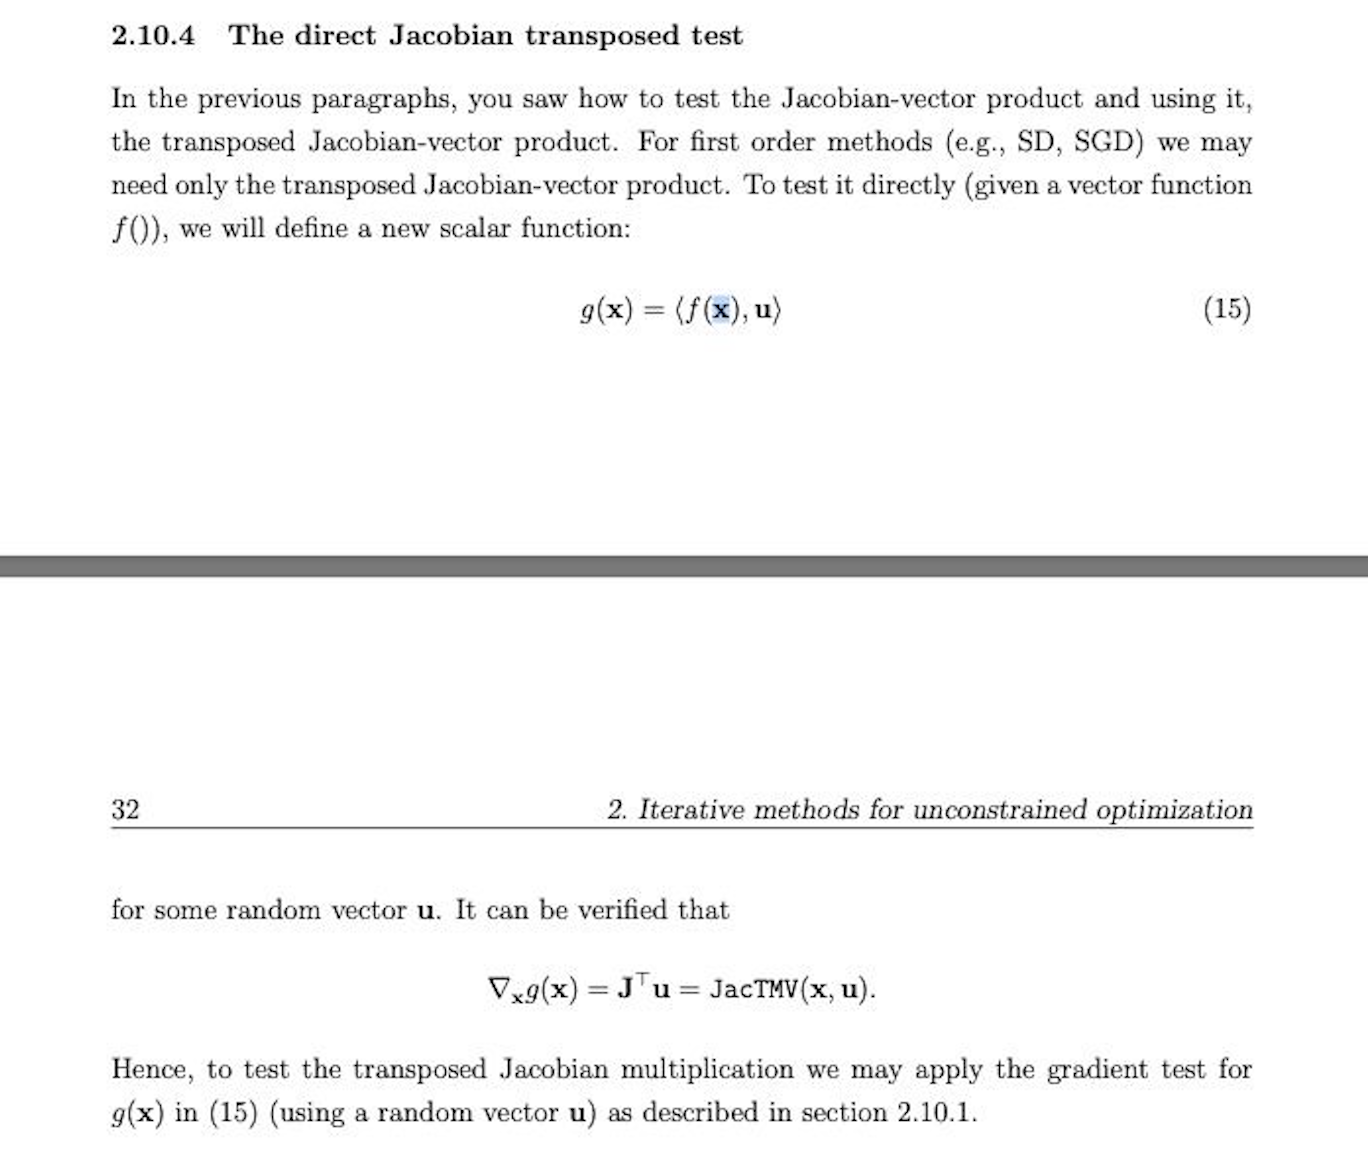

**we'll use two linear layers followed by our softmax layer. we'll plot the graphs for the linear layers.**

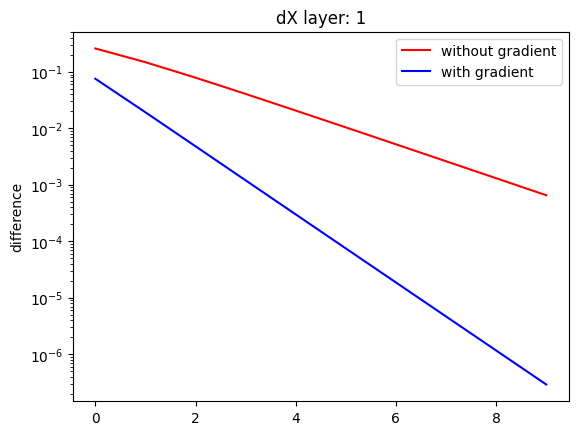

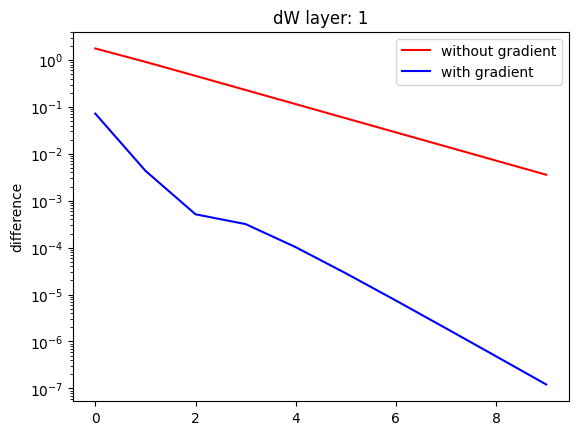

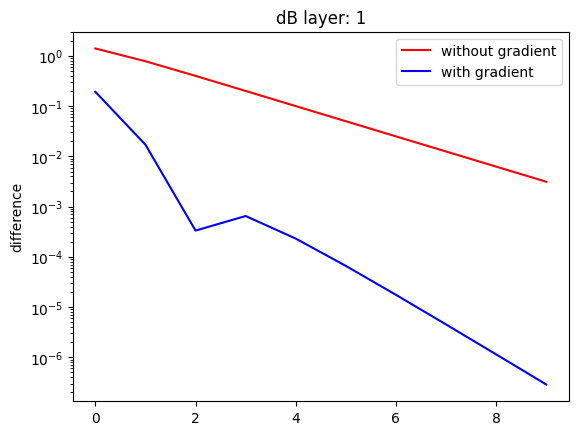

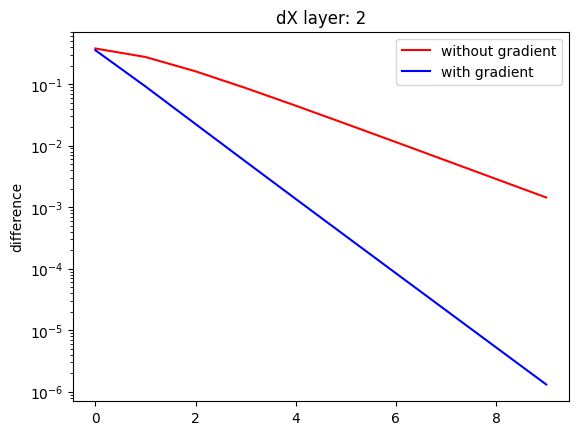

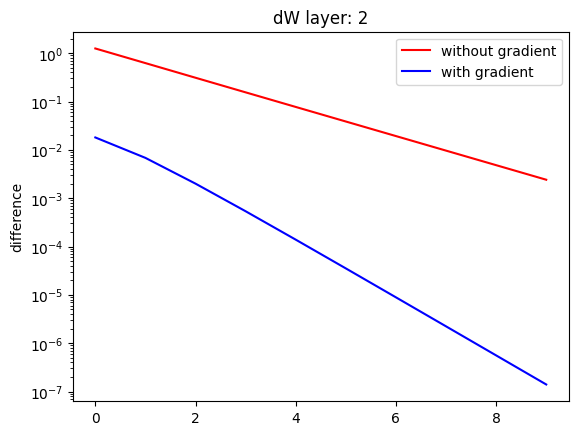

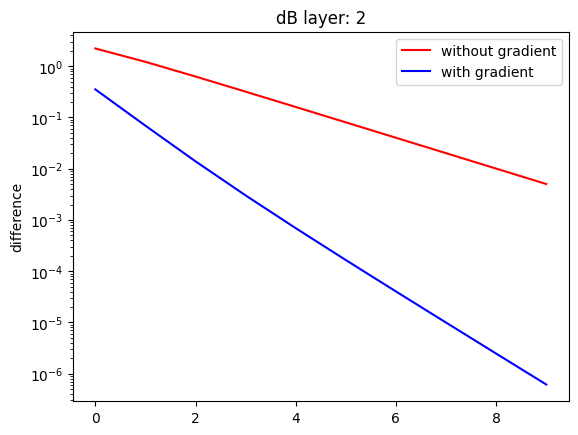

In [53]:
# jacobian test
n = 2
l = 5
m = 3
X = np.random.rand(n, m)
# np.eye(n_classes)[np.random.choice(n_classes, n_samples)]
C =np.eye(l)[np.random.choice(l, m)].T
# nn = NeuralNetwork([[2,3],[3,16],[16,5]],activation='tanh')
nn = NeuralNetwork([('linear', [n, 3]), ('linear', [3, 4]), ('softmax', [4, l])], activation='tanh')
nn.forward(X,C)
nn.jac_test_independent()


now lets do it again, using only residual blocks.

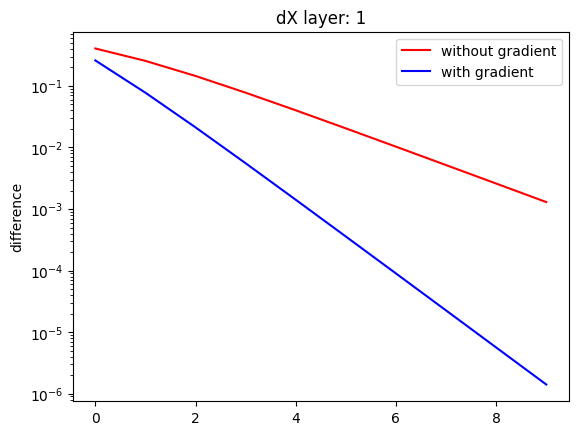

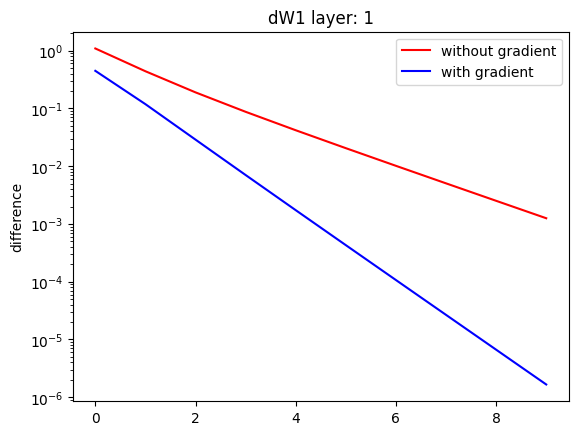

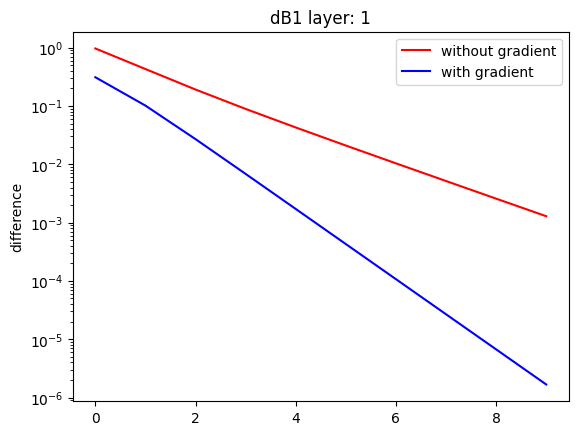

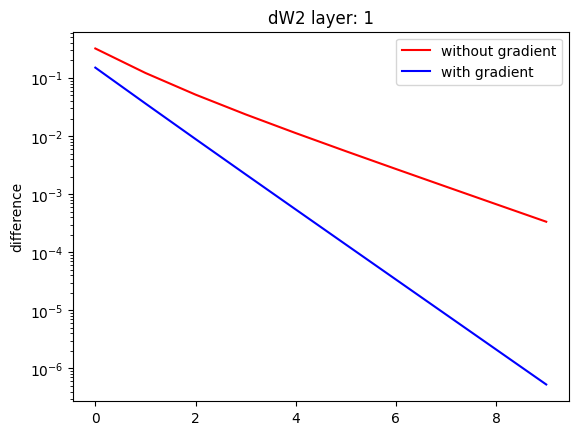

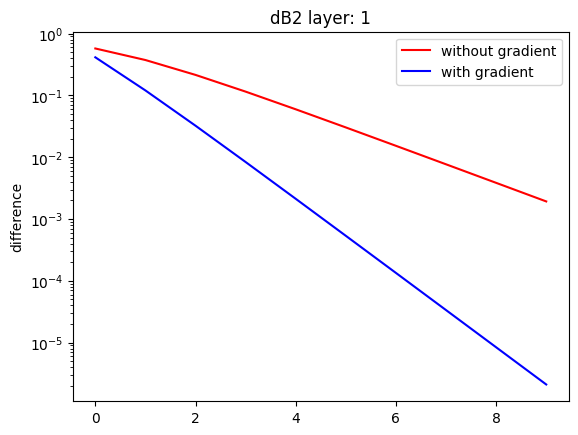

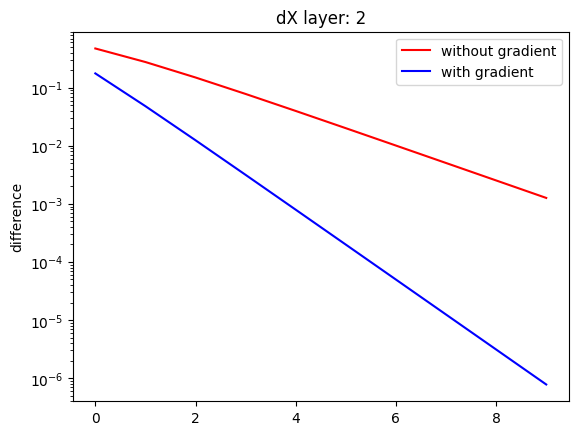

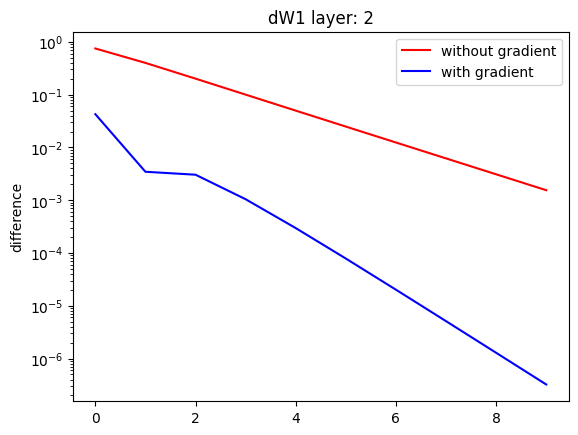

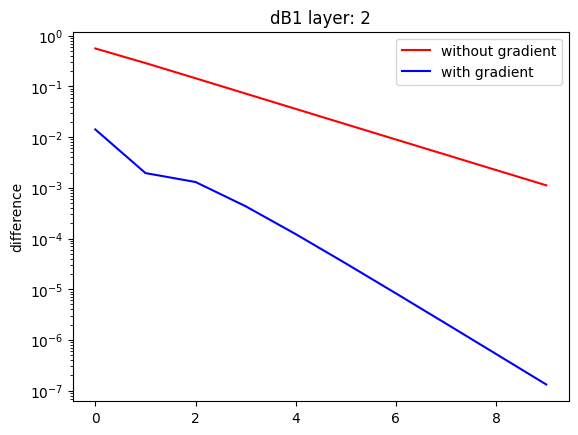

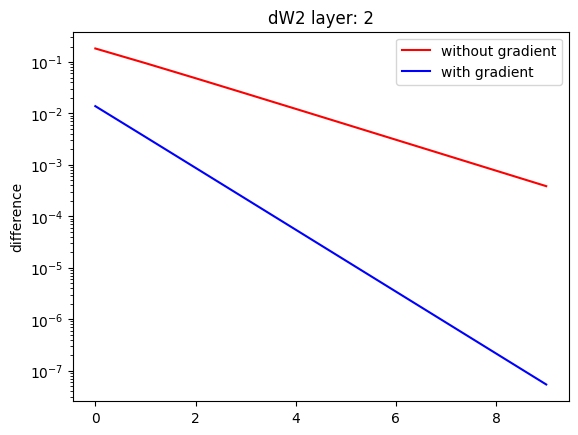

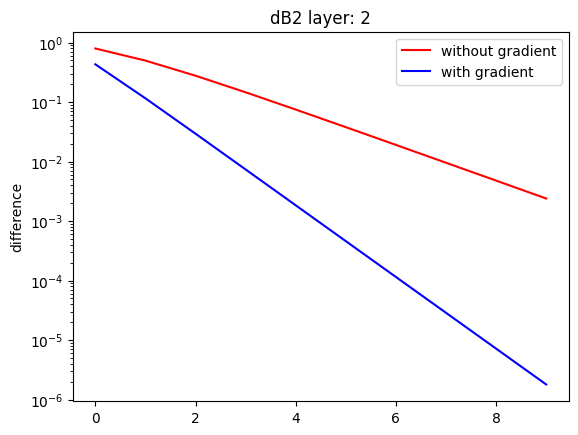

In [54]:
nn = NeuralNetwork([('resblock', [n, 3]), ('resblock', [n, 4]), ('softmax', [n, l])], activation='tanh')

nn.forward(X,C)
nn.jac_test_independent()


now, lets try combining both linear layers and residual blocks.

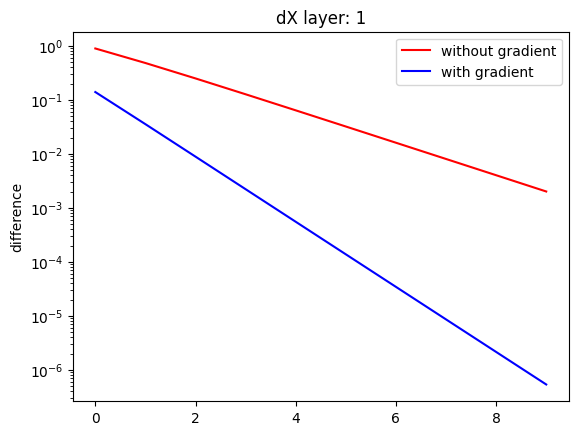

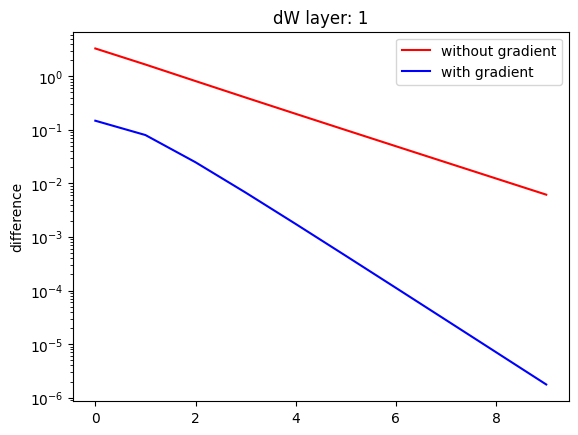

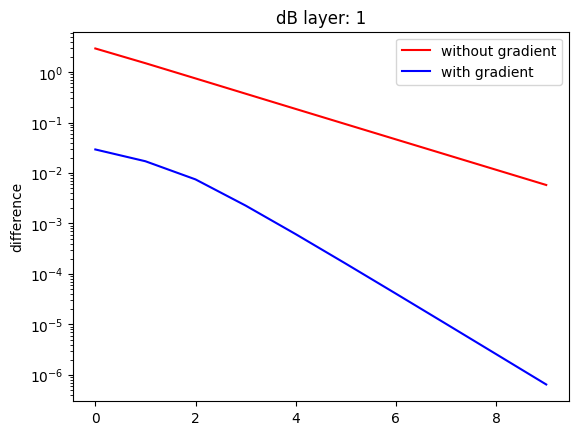

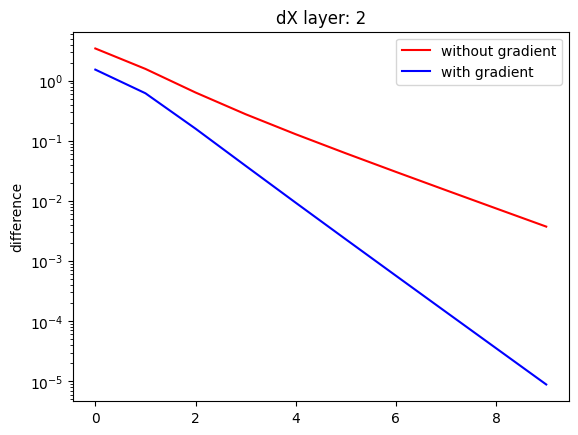

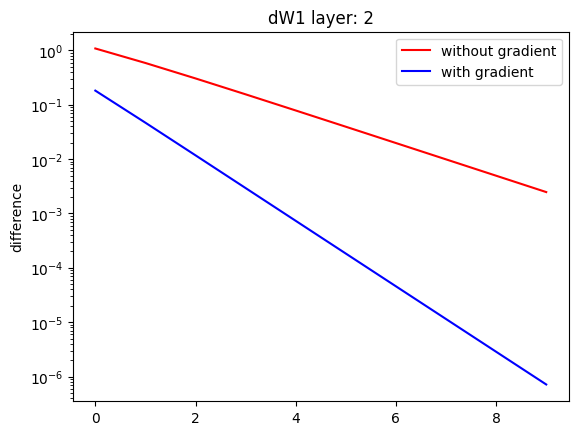

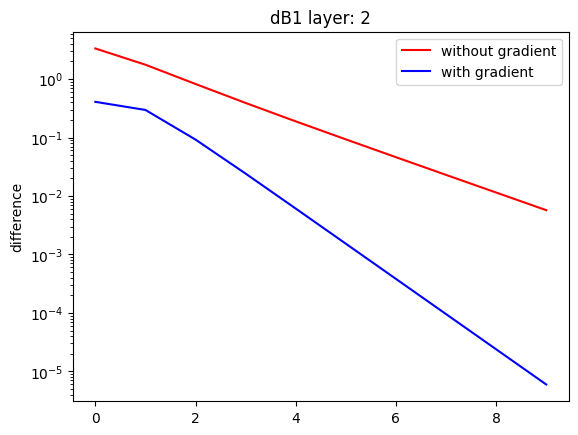

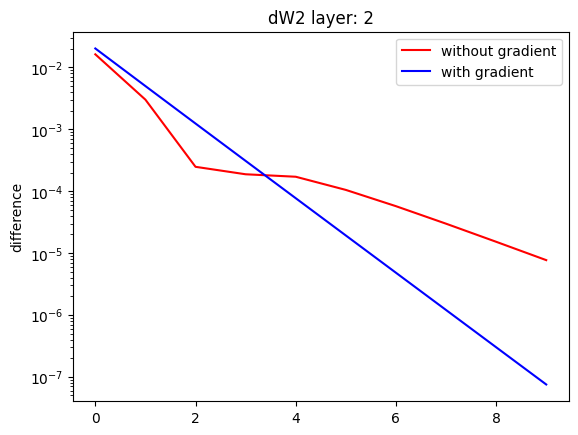

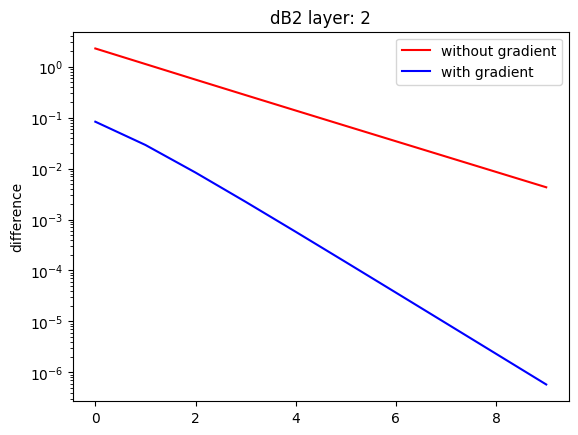

In [55]:
nn = NeuralNetwork([('linear', [n, 5]), ('resblock', [5, 10]),('softmax', [5, l])], activation='tanh')
nn.forward(X,C)
nn.jac_test_independent()

### ***Gradients tests***

first, lets test the gradients for the entire network, using only linear layers.

In [56]:

nn = NeuralNetwork([('linear', [n, 3]), ('linear', [3, 4]), ('softmax', [4, l])], activation='tanh')
nn.forward(X,C)
nn.grad_test()


ValueError: shapes (3,4) and (3,5) not aligned: 4 (dim 1) != 3 (dim 0)

now,lets try adding residual blocks.

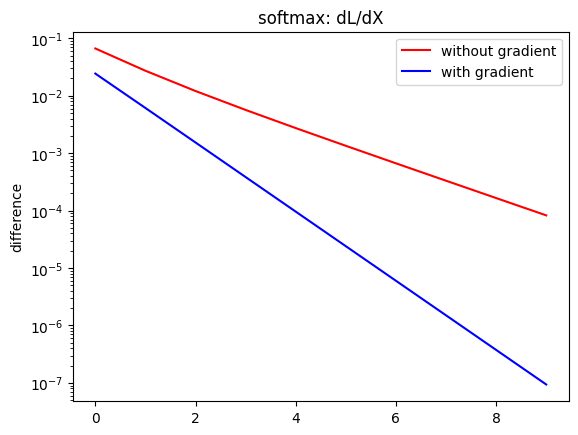

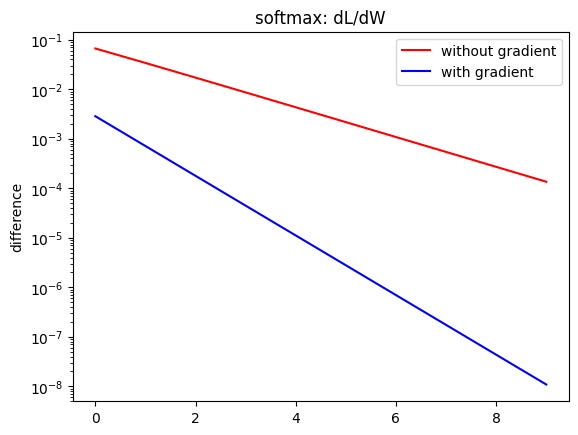

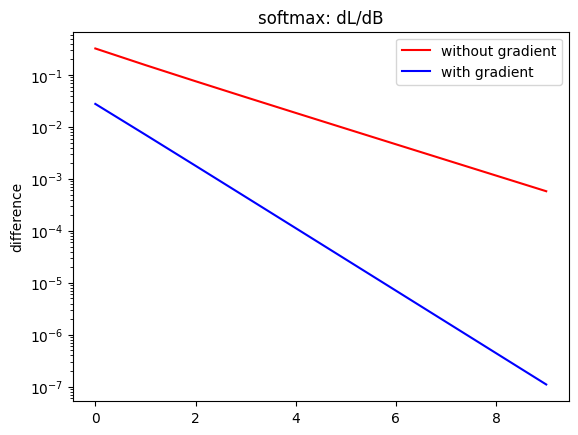

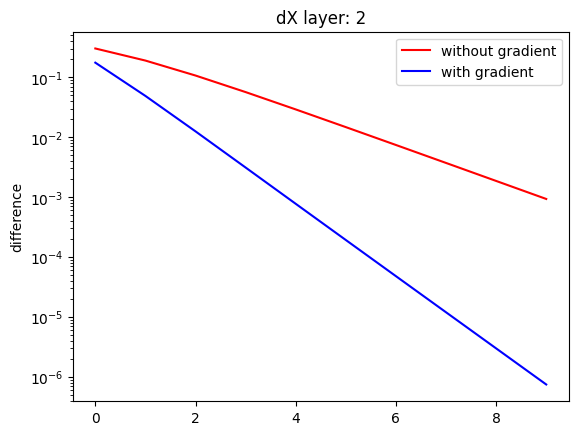

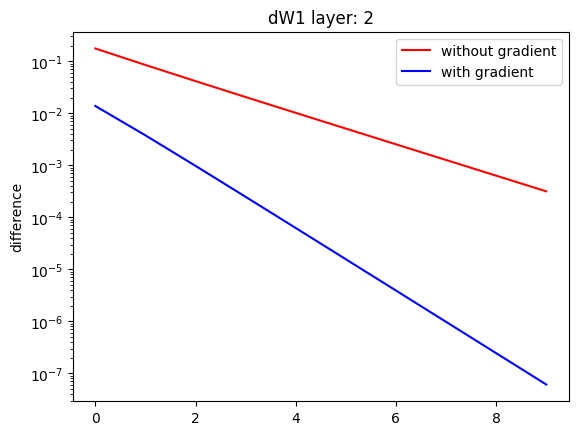

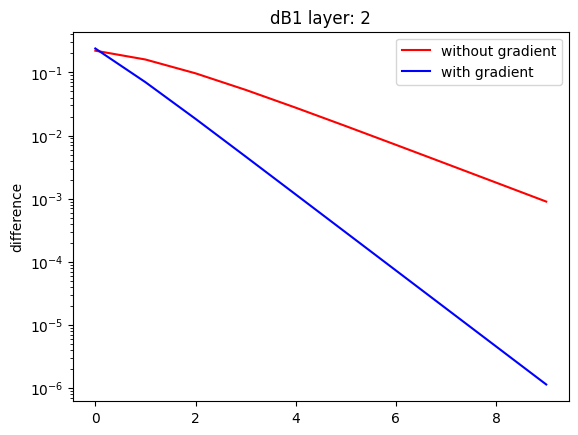

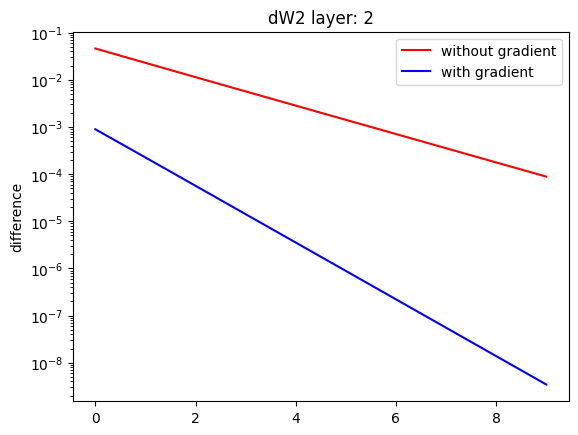

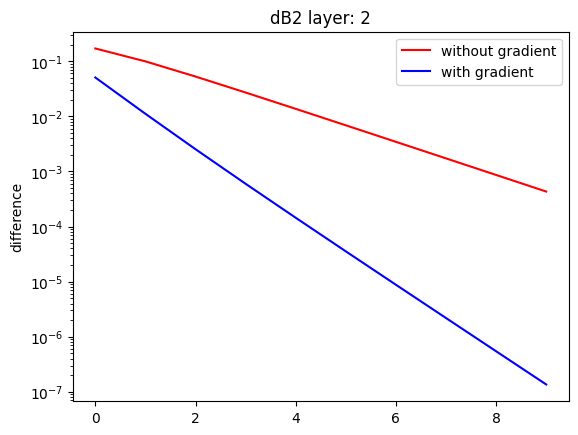

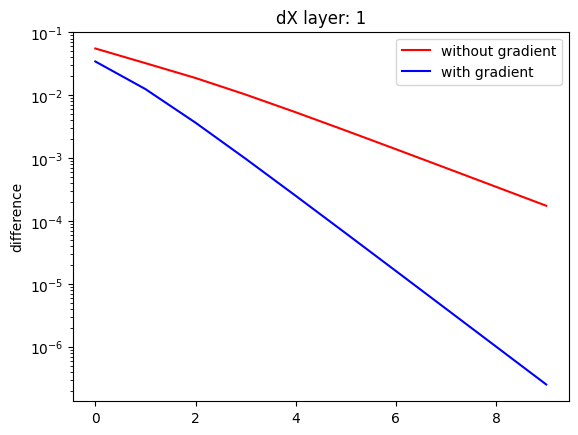

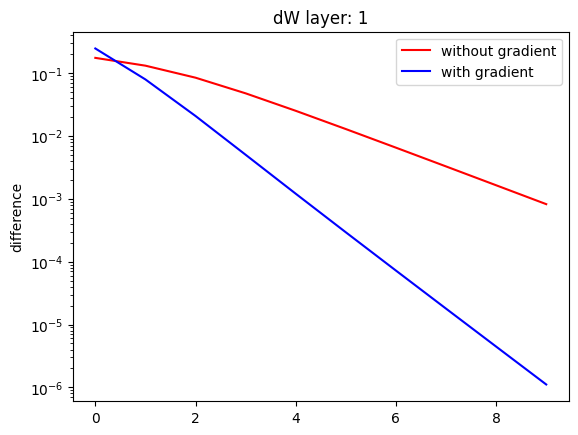

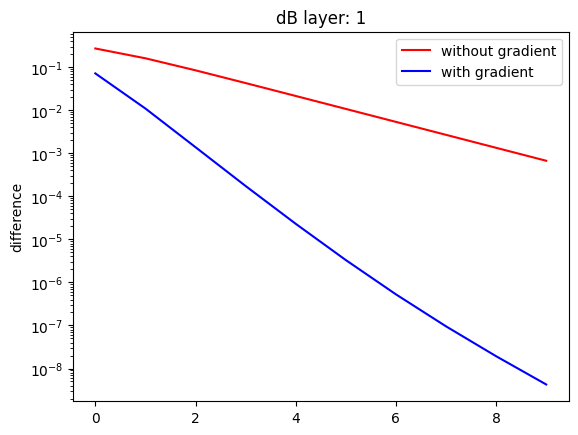

In [ ]:
nn = NeuralNetwork([('linear', [n, 5]), ('resblock', [5, 10]),('softmax', [5, l])], activation='tanh')
nn.forward(X,C)
nn.grad_test()

## ***Training The Neural Network***

we'll adapt our previous training loop for the full neural network.

In [ ]:
def train_and_plot(model, x_train, y_train, x_val, y_val, batch_size=64, accuracy_batch_size=6250, epochs=1000, lr=0.000325):
    num_data_points_train = x_train.shape[1]
    num_data_points_val = x_val.shape[1]

    num_batches_train = num_data_points_train // batch_size
    num_batches_val = num_data_points_val // batch_size

    losses_train = []
    losses_val = []
    accuracies_train = []
    accuracies_val = []

    indices_train = np.arange(num_data_points_train)
    indices_val = np.arange(num_data_points_val)
    for epoch in range(epochs):
        if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}")

        # Shuffle the data indices for each epoch
        np.random.shuffle(indices_train)
        np.random.shuffle(indices_val)


         # ## Test accuracy for training data ##
        x_batch = x_train[:, indices_train[:accuracy_batch_size]]
        y_batch = y_train[:, indices_train[:accuracy_batch_size]]
        predicted = np.argmax(model.forward(x_batch,y_batch)[0].T,axis=0) #l*m
        true_labels = np.argmax(y_batch, axis=0)
        accuracies_train.append(calculate_accuracy(predicted, true_labels))

        ## Test accuracy for validation data ##
        x_batch = x_val[:, indices_val[:accuracy_batch_size]]
        y_batch = y_val[:, indices_val[:accuracy_batch_size]]
        predicted = np.argmax(model.forward(x_batch,y_batch)[0].T,axis=0) #l*m
        true_labels = np.argmax(y_batch, axis=0)
        accuracies_val.append(calculate_accuracy(predicted, true_labels))

        # Validation data ##
        loss_val = 0
        for i in range(0, num_data_points_val, batch_size):
            batch_indices = indices_val[i:i + batch_size]
            x_batch_v = x_val[:, batch_indices]
            y_batch_v = y_val[:, batch_indices]
            loss_val += model.forward(x_batch_v, y_batch_v)[1] #[1] for the loss

        ## Training data ##
        loss_train = 0
        for i in range(0, num_data_points_train, batch_size):
            batch_indices = indices_train[i:i + batch_size]

            # Get batch data
            x_batch = x_train[:, batch_indices]
            y_batch = y_train[:, batch_indices]

            loss_train += model.forward(x_batch, y_batch)[1]# [1] for the loss
            model.backprop(lr=lr)



        loss_train /= num_batches_train
        loss_val /= num_batches_val
        losses_train.append(loss_train)
        losses_val.append(loss_val)

    plt.plot(losses_train, label="train loss", color="blue")
    plt.plot(losses_val, label="test loss", color="orange")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

    plt.plot(accuracies_train, label="train accuracy", color="blue")
    plt.plot(accuracies_val, label="test accuracy", color="orange")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

    print("Training completed.")
    print(accuracies_val)

*now lets create our neural network! we'll demonstrate several network architectures.*
we'll use the peaks dataset for our demonstration, and later we'll advance to the GMM dataset.


First, lets create a simple network with linear layers only.

In [ ]:
 # peaks_model = NeuralNetwork(layers = [[2,16],[16,32],[32,64],[64,32],[32,16],[16,5]])
peaks_model = NeuralNetwork(layers = [('linear',[2,16]),('linear',[16,32]),('linear',[32,64]),('linear',[64,32]),('linear',[32,16]),('softmax',[16,5])])
print(peaks_model.toString)
print("total params: %d"%peaks_model.total_params)

NeuralNetwork:
Linear: [2, 16]
Linear: [16, 32]
Linear: [32, 64]
Linear: [64, 32]
Linear: [32, 16]
Softmax: [16, 5]

total params: 5397


great, now lets train our network!


*   first, lets choose some hyper parameters.
*   then, we can start the training process.



For our first linear network, we found these parameters to be the best:

In [ ]:
### HYPER PARAMETERTS ###

batch_size = 32
lr = 0.000325
epochs = 500
#########################

We did not see much improvement after using more than 500 epochs.

Epoch 1/500
Epoch 101/500
Epoch 201/500
Epoch 301/500
Epoch 401/500


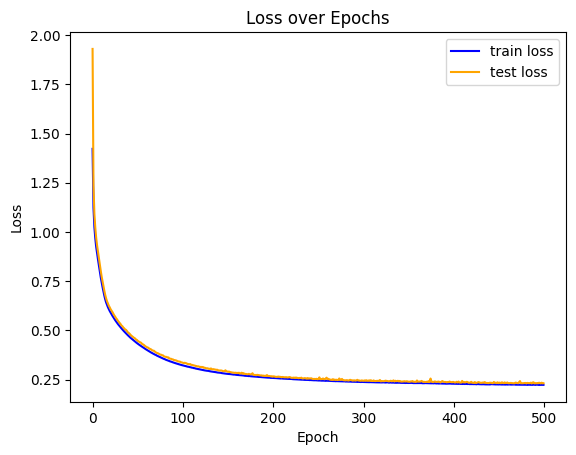

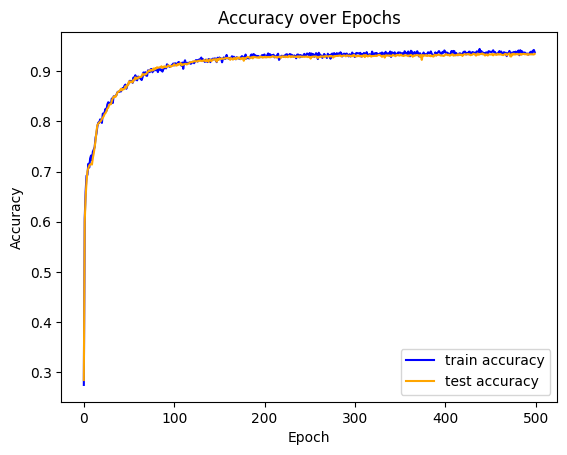

Training completed.
[0.28416, 0.59952, 0.6496, 0.68, 0.70048, 0.70704, 0.71184, 0.71424, 0.7152, 0.71408, 0.72736, 0.73648, 0.74864, 0.7624, 0.78048, 0.7928, 0.79568, 0.79776, 0.79984, 0.80128, 0.8048, 0.80752, 0.8104, 0.81488, 0.8168, 0.82032, 0.8256, 0.82736, 0.83296, 0.83456, 0.8344, 0.84128, 0.84608, 0.84912, 0.85056, 0.84896, 0.85216, 0.85728, 0.85936, 0.85968, 0.86192, 0.86512, 0.86208, 0.86528, 0.864, 0.8656, 0.87024, 0.8672, 0.87312, 0.87264, 0.88016, 0.87776, 0.87984, 0.87968, 0.87792, 0.8832, 0.88336, 0.88816, 0.88512, 0.8856, 0.888, 0.88752, 0.88896, 0.8888, 0.88992, 0.89488, 0.89376, 0.8928, 0.89456, 0.89456, 0.89744, 0.89952, 0.9016, 0.90048, 0.90288, 0.90192, 0.90176, 0.90576, 0.90336, 0.9064, 0.90544, 0.90816, 0.90752, 0.90752, 0.90816, 0.9088, 0.91024, 0.90656, 0.908, 0.91008, 0.90944, 0.90816, 0.90896, 0.91168, 0.91152, 0.91072, 0.90912, 0.91024, 0.91104, 0.91152, 0.9144, 0.91264, 0.91152, 0.91168, 0.91488, 0.91312, 0.91456, 0.91664, 0.912, 0.91408, 0.91328, 0.9144, 0.

In [ ]:


train_and_plot(peaks_model, x_train, y_train, x_val, y_val,batch_size,epochs = epochs,lr = lr)


Now, lets try using our residual blocks!



In [ ]:
resnet_peaks = NeuralNetwork(layers = [('linear',[2,32]),('resblock',[32,32]),('resblock',[32,64]),('resblock',[32,32]),('softmax',[32,5])])
print(resnet_peaks.toString)
print("total params: %d"%resnet_peaks.total_params)


NeuralNetwork:
Linear: [2, 32]
ResBlock: [32, 32]
ResBlock: [32, 64]
ResBlock: [32, 32]
Softmax: [32, 5]

total params: 8677


We found a batch size of 32 and a learning rate of 0.0001 to be the best after trying several configurations

Epoch 1/1000
Epoch 101/1000
Epoch 201/1000
Epoch 301/1000
Epoch 401/1000
Epoch 501/1000
Epoch 601/1000
Epoch 701/1000
Epoch 801/1000
Epoch 901/1000


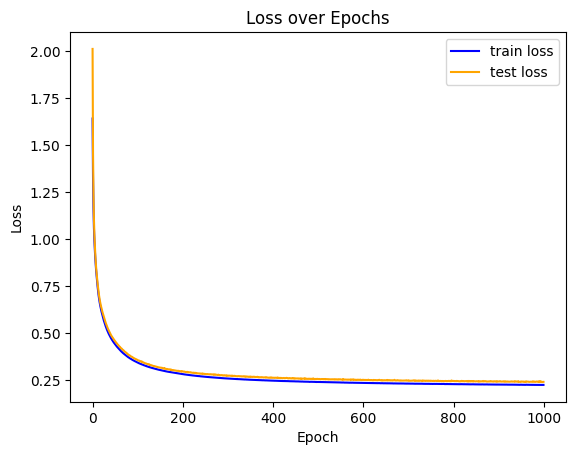

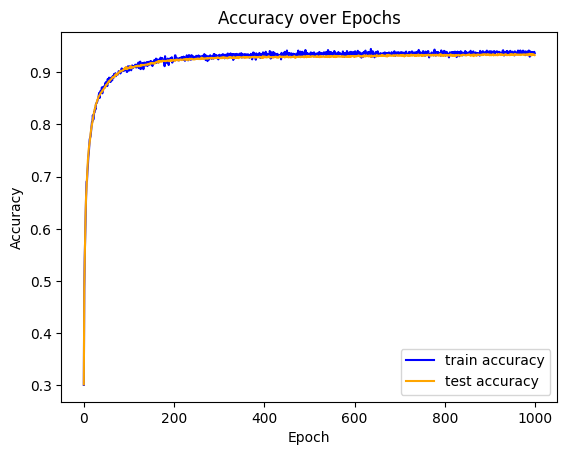

Training completed.
[0.30192, 0.4872, 0.54096, 0.5872, 0.63136, 0.66224, 0.67952, 0.69872, 0.71776, 0.73184, 0.74144, 0.75376, 0.76032, 0.76656, 0.77296, 0.78256, 0.7888, 0.79552, 0.79936, 0.80496, 0.81184, 0.81568, 0.82064, 0.82384, 0.82976, 0.83024, 0.8368, 0.83856, 0.84096, 0.84432, 0.84704, 0.848, 0.85168, 0.85392, 0.85488, 0.85584, 0.85776, 0.85968, 0.86128, 0.86192, 0.86224, 0.86512, 0.86544, 0.86592, 0.86864, 0.86912, 0.87024, 0.87216, 0.872, 0.87584, 0.876, 0.87648, 0.8784, 0.87952, 0.8808, 0.8824, 0.88192, 0.88304, 0.88448, 0.88592, 0.8864, 0.88688, 0.88816, 0.8896, 0.89008, 0.89104, 0.89024, 0.892, 0.89104, 0.89344, 0.89584, 0.8944, 0.8952, 0.89696, 0.8952, 0.89696, 0.89872, 0.89888, 0.89952, 0.90144, 0.90096, 0.90272, 0.90224, 0.90192, 0.90288, 0.90352, 0.90336, 0.90368, 0.9048, 0.90624, 0.90624, 0.90832, 0.9072, 0.90976, 0.90688, 0.90976, 0.90592, 0.90672, 0.90816, 0.90832, 0.9088, 0.90976, 0.908, 0.91104, 0.90768, 0.91152, 0.9088, 0.90992, 0.90912, 0.90992, 0.91024, 0.9105

In [ ]:
train_and_plot(resnet_peaks, x_train, y_train, x_val, y_val,batch_size,epochs = 1000,lr = 0.0001)


lets now train our network on the more complicated GMM dataset

In [ ]:
GMM = scipy.io.loadmat('GMMDATA.mat')
x_train = np.array(GMM['Yt'])
y_train = np.array(GMM['Ct'])
x_val = np.array(GMM['Yv'])
y_val = np.array(GMM['Cv'])

We'll use the same model architecture as before, along with the same hyperparameter configuration.

NeuralNetwork:
Linear: [5, 32]
ResBlock: [32, 32]
ResBlock: [32, 64]
ResBlock: [32, 32]
Softmax: [32, 5]

total params: 8773
Epoch 1/1000
Epoch 101/1000
Epoch 201/1000
Epoch 301/1000
Epoch 401/1000
Epoch 501/1000
Epoch 601/1000
Epoch 701/1000
Epoch 801/1000
Epoch 901/1000


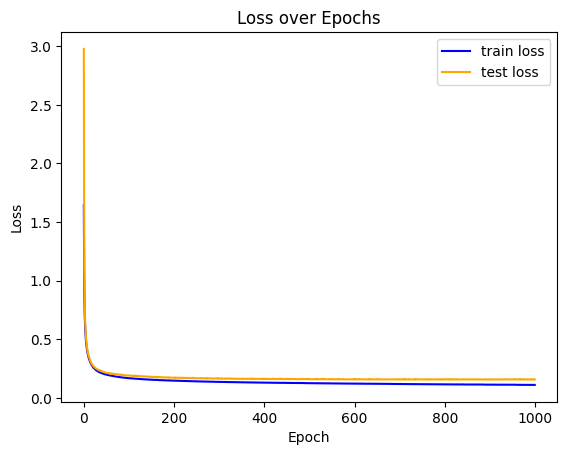

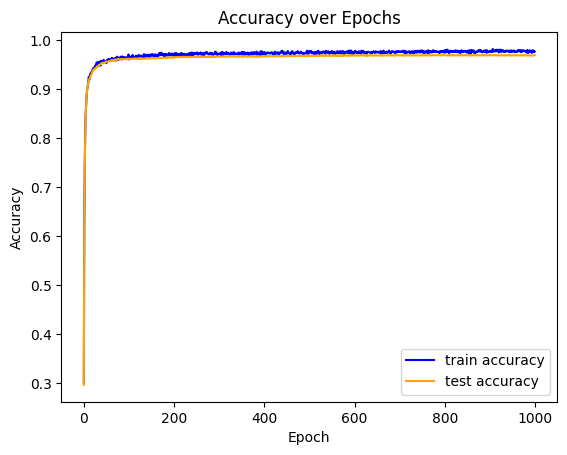

Training completed.
[0.29632, 0.61632, 0.73104, 0.79472, 0.83952, 0.86752, 0.88464, 0.89392, 0.90384, 0.90736, 0.9128, 0.91536, 0.92, 0.92176, 0.92496, 0.92512, 0.92848, 0.9312, 0.93328, 0.93536, 0.93776, 0.93824, 0.94032, 0.94016, 0.94016, 0.94144, 0.9424, 0.94352, 0.944, 0.94544, 0.94544, 0.94672, 0.94656, 0.94848, 0.94928, 0.94864, 0.94976, 0.95024, 0.952, 0.95152, 0.95248, 0.95296, 0.95328, 0.95376, 0.95328, 0.9536, 0.95408, 0.95456, 0.95488, 0.95568, 0.95536, 0.95552, 0.95568, 0.956, 0.95616, 0.95568, 0.95664, 0.95728, 0.95712, 0.9576, 0.95792, 0.9584, 0.95744, 0.95856, 0.9584, 0.9584, 0.95888, 0.9592, 0.95856, 0.95984, 0.9592, 0.95984, 0.95952, 0.95984, 0.9608, 0.9608, 0.96048, 0.95984, 0.96064, 0.96064, 0.96064, 0.96032, 0.96048, 0.96128, 0.9608, 0.9608, 0.96112, 0.96112, 0.96096, 0.9608, 0.9608, 0.96112, 0.96096, 0.96128, 0.96112, 0.96112, 0.96096, 0.96192, 0.96144, 0.96112, 0.96192, 0.96128, 0.96112, 0.96112, 0.9616, 0.96144, 0.9616, 0.96176, 0.96176, 0.96144, 0.9616, 0.96192,

In [ ]:

gmm_net = NeuralNetwork(layers = [('linear',[5,32]),('resblock',[32,32]),('resblock',[32,64]),('resblock',[32,32]),('softmax',[32,5])])
print(gmm_net.toString)
print("total params: %d"%gmm_net.total_params)

train_and_plot(gmm_net, x_train, y_train, x_val, y_val,batch_size,epochs = 1000,lr = 0.000325)



For all of our networks, we've tried several hyperparameters, different depths and widths, and different activation functions. We've submitted our most successful results. For example, we tried drastically increasing the number of parameters, using a network with 10 res blocks and around 100,000 parameters. We did not see a significant improvement in accuracy, though the running time was much longer.


now, lets try using the same network from before, but using only 200 samples for training.

NeuralNetwork:
Linear: [5, 32]
ResBlock: [32, 32]
ResBlock: [32, 64]
ResBlock: [32, 32]
Softmax: [32, 5]

total params: 8773
Epoch 1/1000
Epoch 101/1000
Epoch 201/1000
Epoch 301/1000
Epoch 401/1000
Epoch 501/1000
Epoch 601/1000
Epoch 701/1000
Epoch 801/1000
Epoch 901/1000


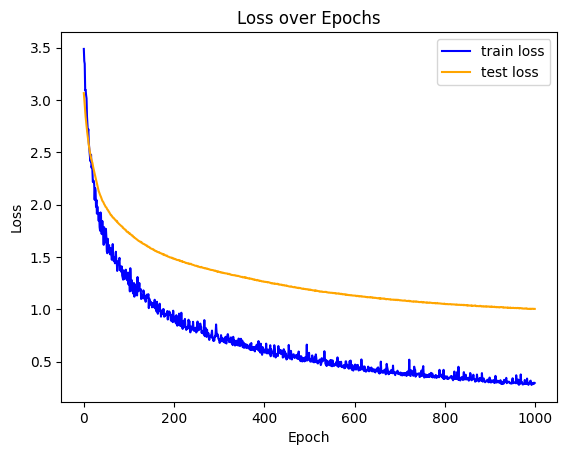

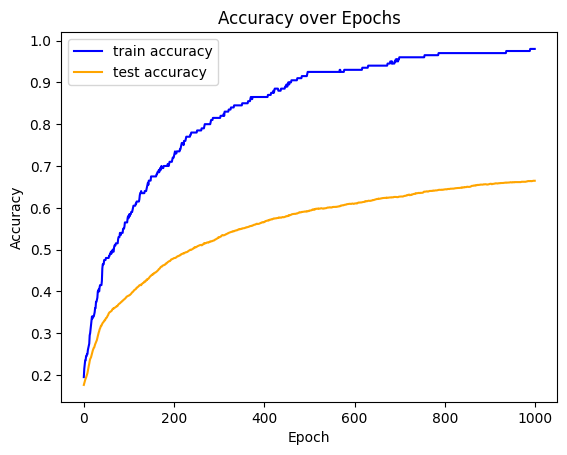

Training completed.
[0.17632, 0.18048, 0.18384, 0.18816, 0.19152, 0.19392, 0.19744, 0.20048, 0.20448, 0.21056, 0.21552, 0.22208, 0.22704, 0.23344, 0.23808, 0.24016, 0.24256, 0.24672, 0.25024, 0.25552, 0.2592, 0.26176, 0.26496, 0.26576, 0.26944, 0.27328, 0.27584, 0.27856, 0.28096, 0.28384, 0.28912, 0.29328, 0.29808, 0.30176, 0.3048, 0.30928, 0.31152, 0.31456, 0.31776, 0.31792, 0.3208, 0.32304, 0.3248, 0.32592, 0.32736, 0.32944, 0.33088, 0.33088, 0.33376, 0.33616, 0.33664, 0.33776, 0.34, 0.34224, 0.34368, 0.34704, 0.3488, 0.35008, 0.35072, 0.35136, 0.35232, 0.35328, 0.35408, 0.3568, 0.35808, 0.35904, 0.35856, 0.36016, 0.36048, 0.36128, 0.36224, 0.36288, 0.36368, 0.36496, 0.36464, 0.36576, 0.368, 0.36912, 0.37024, 0.37104, 0.37152, 0.37264, 0.37408, 0.37488, 0.37536, 0.37696, 0.37776, 0.3784, 0.38, 0.38064, 0.38128, 0.38256, 0.38336, 0.3848, 0.38624, 0.38752, 0.388, 0.3888, 0.38928, 0.3896, 0.39008, 0.3912, 0.39136, 0.39248, 0.39392, 0.39472, 0.39632, 0.39776, 0.39856, 0.3992, 0.4008, 0.4

In [ ]:
indicies = np.arange(x_train.shape[1])
np.random.shuffle(indicies)
x_train = x_train[:,indicies[:200]]
y_train = y_train[:,indicies[:200]]
gmm_net = NeuralNetwork(layers = [('linear',[5,32]),('resblock',[32,32]),('resblock',[32,64]),('resblock',[32,32]),('softmax',[32,5])])
print(gmm_net.toString)
print("total params: %d"%gmm_net.total_params)

train_and_plot(gmm_net, x_train, y_train, x_val, y_val,batch_size,epochs = 1000,lr = 0.000325)


When we utilized the entire dataset, we achieved an accuracy score of around 96 to 97 percent on the test set. Now, with only 200 samples and employing the same network and hyperparameters, we've attained an accuracy score of 0.66. It's also worth mentioning that our accuracy on the training set is very close to 1, indicating overfitting of our network to the training set (the 200 samples).